# PREPROCESSING AND MODEL CREATION

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import os

In [43]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [44]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

In [45]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

In [46]:
# Edge Case: Check for missing values
if df.isnull().sum().sum() > 0:
    print("Warning: Missing values detected. Filling with mean.")
    df.fillna(df.mean(), inplace=True)

In [47]:
# Feature Engineering: Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
poly_feature_names = poly.get_feature_names_out(feature_names)
print(f"Number of features after polynomial expansion: {X_poly.shape[1]}")

Number of features after polynomial expansion: 14


In [48]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# Preprocessing: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Define the neural network model
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [51]:
# Create and train the model
model = create_model(X_train_scaled.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=16, 
                    validation_split=0.2, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.3548 - loss: 1.9265 - val_accuracy: 0.7083 - val_loss: 1.5022
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4135 - loss: 1.7461 - val_accuracy: 0.6667 - val_loss: 1.4018
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5190 - loss: 1.5738 - val_accuracy: 0.6250 - val_loss: 1.3226
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5659 - loss: 1.4450 - val_accuracy: 0.5000 - val_loss: 1.2585
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5960 - loss: 1.2660 - val_accuracy: 0.7500 - val_loss: 1.2103
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6626 - loss: 1.1450 - val_accuracy: 0.7083 - val_loss: 1.1741
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6725 - loss: 1.1191 - val_accuracy: 0.7083 - val_loss: 1.1449
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6885 - loss: 1.0946 - val_accuracy: 0.6667 - val_loss

In [52]:
# Evaluate briefly on test set to confirm it works
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9333


In [53]:
# Create the models directory at the project root
os.makedirs('../models', exist_ok=True)

# Save the model in SavedModel format
model.save('../models/model.keras')

# Save preprocessing objects
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('../models/poly.pkl', 'wb') as f:
    pickle.dump(poly, f)

# MODEL EVALUATION AND VISUALIZATION

In [54]:
# Load the saved model and preprocessing objects
model = tf.keras.models.load_model('../models/model.keras')
with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('../models/poly.pkl', 'rb') as f:
    poly = pickle.load(f)

In [55]:
# Make predictions on the test set
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


In [56]:
# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9333


In [57]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



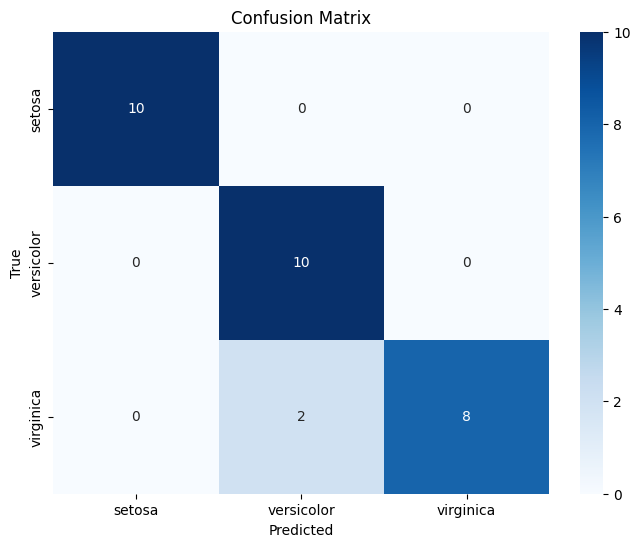

In [58]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

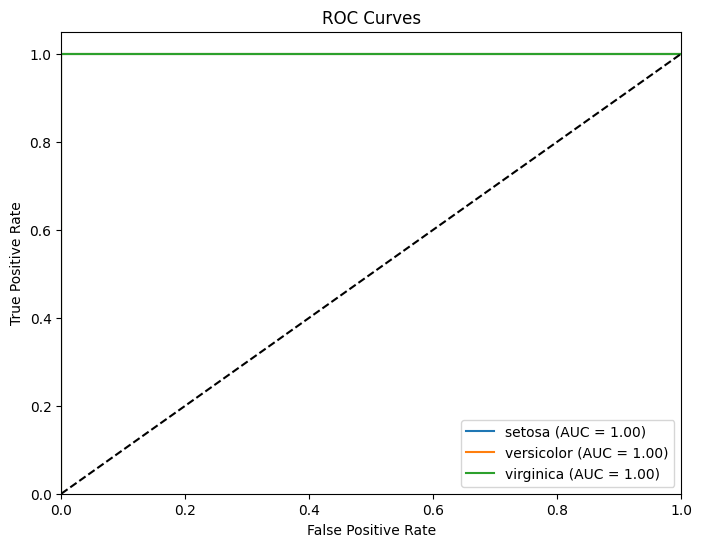

In [59]:
# Compute and plot ROC curves for each class
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
plt.figure(figsize=(8, 6))
for i in range(3):
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_probs[:, i])
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'{iris.target_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [60]:
# Plot training history from Task 1
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

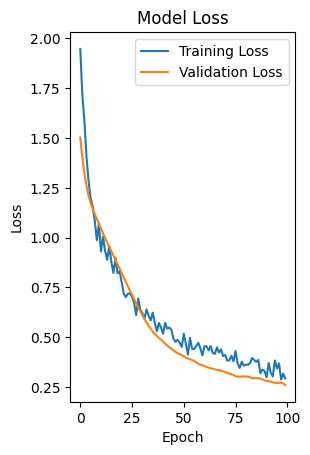

In [61]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

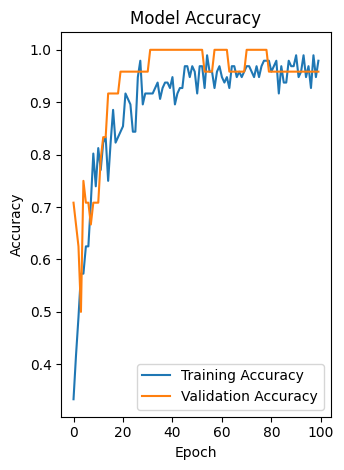

In [62]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
# Analyze misclassified samples
misclassified_idx = np.where(y_pred != y_test)[0]
if len(misclassified_idx) > 0:
    print("\nMisclassified Samples:")
    for idx in misclassified_idx:
        print(f"True: {iris.target_names[y_test[idx]]}, Predicted: {iris.target_names[y_pred[idx]]}")
else:
    print("\nNo misclassified samples.")


Misclassified Samples:
True: virginica, Predicted: versicolor
True: virginica, Predicted: versicolor


# FEATURE VISUALIZATION AND STORY TELLING

In [64]:
"""
from the classification report it shows that the model struggles a little to distinguish versicolor
from virginica, but excels with setosa some key visualization of the features will help us
understand why.
"""

'\nfrom the classification report it shows that the model struggles a little to distinguish versicolor\nfrom virginica, but excels with setosa some key visualization of the features will help us\nunderstand why.\n'

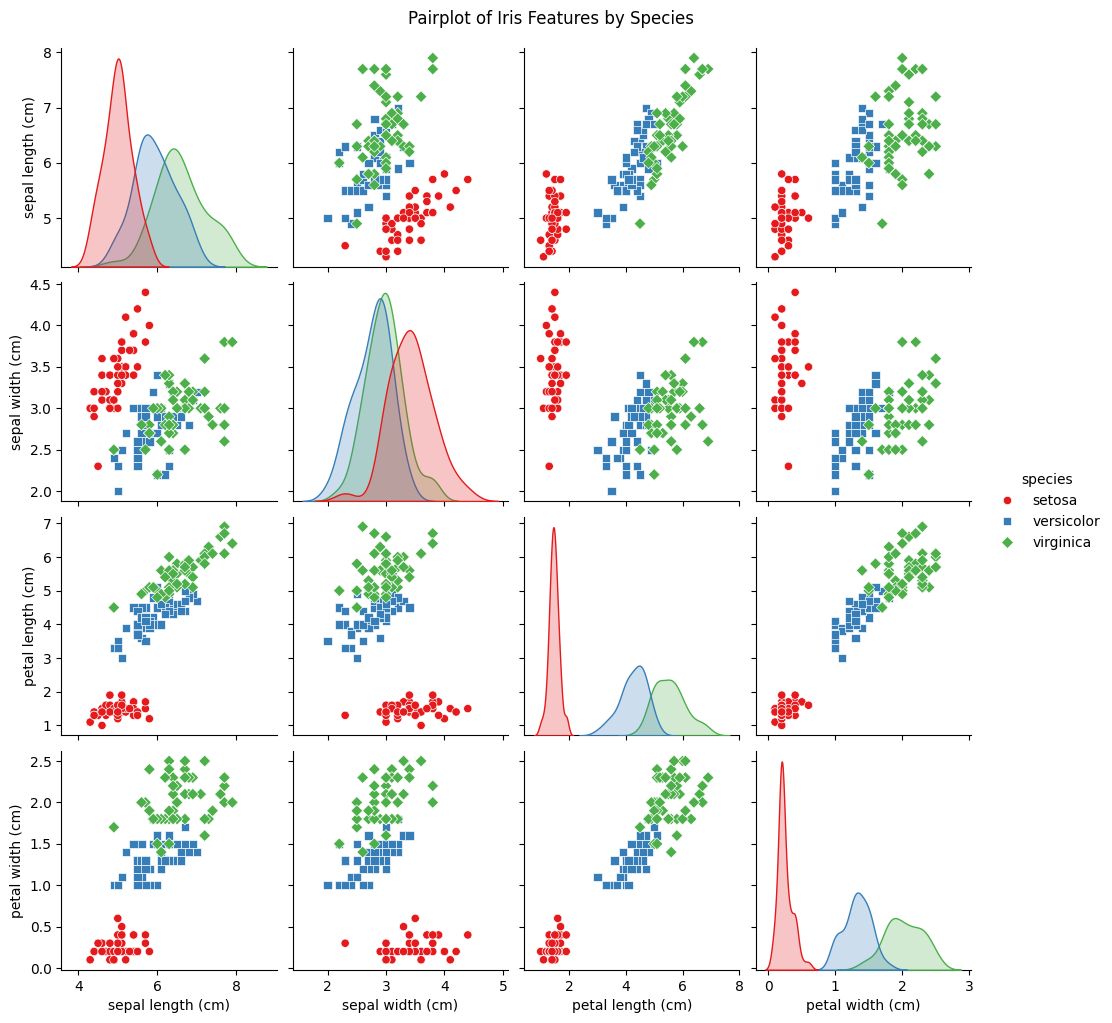

In [65]:
# Create a DataFrame for plotting
df = pd.DataFrame(X, columns=feature_names)
df['species'] = [target_names[i] for i in y]

# Visualization 1: Pairplot
sns.pairplot(df, hue='species', markers=["o", "s", "D"], palette='Set1')
plt.suptitle("Pairplot of Iris Features by Species", y=1.02)
plt.show()

C:\Users\obolo\AppData\Local\Temp\ipykernel_2392\3255805917.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='species', y=feature, data=df, palette='Set1', legend=False,)
C:\Users\obolo\AppData\Local\Temp\ipykernel_2392\3255805917.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='species', y=feature, data=df, palette='Set1', legend=False,)
C:\Users\obolo\AppData\Local\Temp\ipykernel_2392\3255805917.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='species', y=feature, data=df, palette='Set1', legend=False,)
C:\Users\obolo\AppD

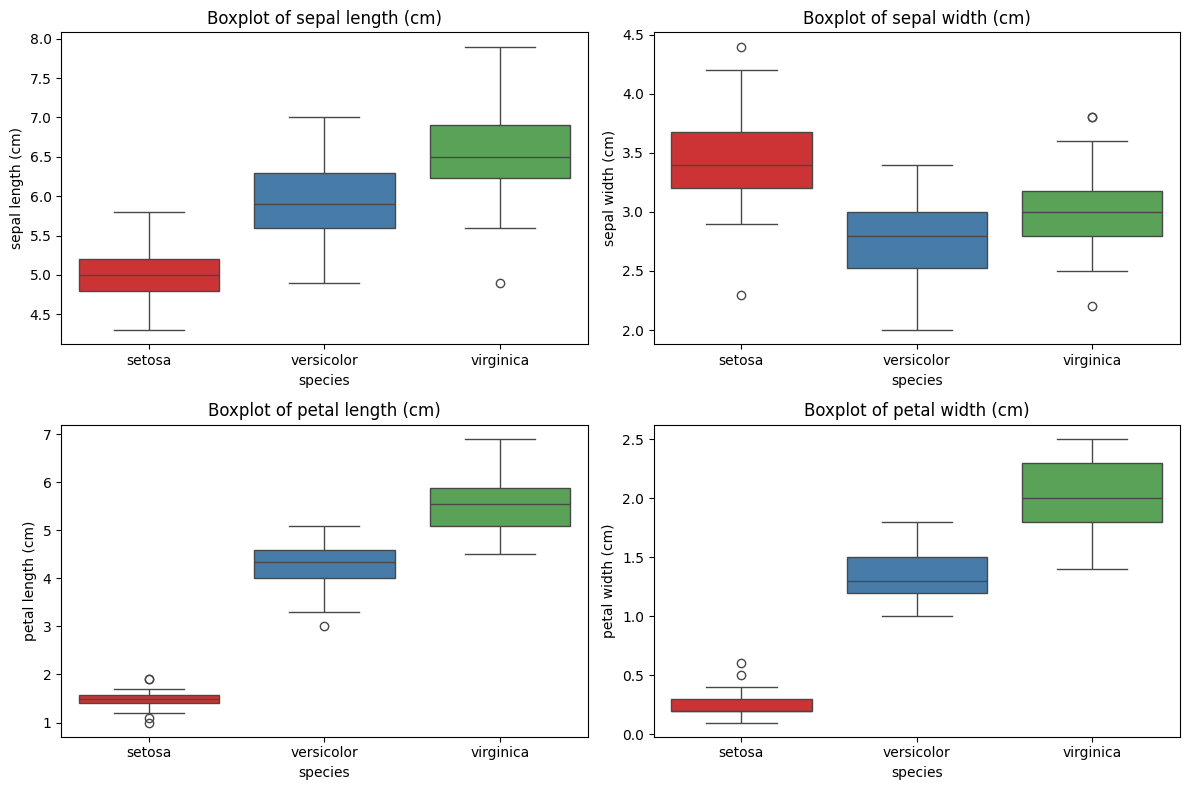

In [66]:
# Visualization 2: Boxplots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='species', y=feature, data=df, palette='Set1', legend=False,)
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

### What These Visualizations Show

#### 1. Pairplot
- **Description**: This creates scatter plots for every pair of features (e.g., sepal length vs. petal width), with points colored by species (setosa, versicolor, virginica). Diagonal plots show the distribution of each feature.
- **What You’ll See**: 
  - Setosa points are tightly clustered and separated from the others, especially in pairs involving petal length and petal width.
  - Versicolor and virginica overlap in some pairs, particularly those with sepal length and sepal width.

#### 2. Boxplots
- **Description**: These show the distribution (median, quartiles, and outliers) of each feature for each species.
- **What You’ll See**: 
  - Petal length and petal width have distinct ranges for each species.
  - Sepal length and sepal width show more overlap, especially between versicolor and virginica.

---

### Interpretations of At Least Three Features

#### 1. Petal Length
- **Observation**: In the boxplot, setosa has much shorter petal lengths (around 1-2 cm), versicolor is intermediate (around 3-5 cm), and virginica has the longest (around 5-7 cm). The pairplot shows setosa separated from the others, with slight overlap between versicolor and virginica.
- **Interpretation**: Petal length is a highly discriminative feature. The model can easily identify setosa due to its small petals, but the slight overlap between versicolor and virginica may contribute to misclassifications.

#### 2. Petal Width
- **Observation**: Similar to petal length, setosa has very narrow petals (around 0.1-0.5 cm), versicolor is wider (around 1-1.5 cm), and virginica is the widest (around 1.5-2.5 cm). The pairplot confirms clear separation for setosa and some overlap between versicolor and virginica.
- **Interpretation**: Petal width is another strong feature for classification. The model likely relies heavily on it, explaining its perfect performance on setosa. The overlap between versicolor and virginica aligns with the misclassifications you observed.

#### 3. Sepal Width
- **Observation**: The boxplot shows setosa with slightly wider sepals (around 3-4 cm), but versicolor and virginica have similar ranges (around 2.5-3.5 cm). The pairplot shows significant overlap between versicolor and virginica.
- **Interpretation**: Sepal width is less discriminative, especially for versicolor vs. virginica. This overlap likely confuses the model, contributing to the misclassification of virginica as versicolor.

#### 4. Sepal Length
- **Observation**: Setosa has shorter sepals (around 4.5-5.5 cm), while versicolor (5-7 cm) and virginica (6-8 cm) overlap more. The pairplot shows setosa somewhat separated but versicolor and virginica mixed.
- **Interpretation**: Sepal length helps distinguish setosa but is less effective for versicolor vs. virginica, adding to the model’s challenges with these classes.

---

### The Story These Features Tell
The visualizations reveal a clear structure in the Iris dataset:
- **Setosa is Easy**: Its small petals (both length and width) and slightly different sepals make it stand out. This explains your model’s perfect precision and recall for setosa.
- **Versicolor vs. Virginica is Tricky**: These two species overlap in all features, especially sepal length and sepal width. While petal length and petal width provide some separation, it’s not perfect. This overlap directly explains your misclassifications—two virginica samples were predicted as versicolor because their feature values likely fell in this ambiguous region.
- **Feature Importance**: The model likely relies more on petal length and petal width (highly discriminative) than sepal length and sepal width (less discriminative), but the sepal features still introduce noise, leading to errors.

In short, the dataset tells a story of one distinct class (setosa) and two similar ones (versicolor and virginica), with the model’s performance reflecting this structure. To improve accuracy, you could focus the model more on petal features or collect more data to better define the versicolor-virginica boundary.